# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Clone the `dlfb` library**  
   First, clone the repository that contains the `dlfb` library.

In [3]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 6.92 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [2]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,graphs,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.10 x86_64-unknown-linux-gnu
Resolved 106 packages in 2.28s
Using Python 3.12.12 environment at: /usr
Resolved 106 packages in 581ms
Prepared 56 packages in 24.43s
Uninstalled 38 packages in 1.26s
Installed 57 packages in 407ms
 - absl-py==1.4.0
 + absl-py==2.3.1
 + adjusttext==1.3.0
 - cachetools==5.5.2
 + cachetools==6.2.2
 - certifi==2025.10.5
 + certifi==2022.12.7
 - charset-normalizer==3.4.4
 + charset-normalizer==2.1.1
 - click==8.3.0
 + click==8.1.8
 + contextlib2==21.6.0
 + dlfb==0.1.1 (from file:///content/dlfb-clone)
 - filelock==3.20.0
 + filelock==3.19.1
 - flax==0.10.7
 + flax==0.10.4
 - fsspec==2025.3.0
 + fsspec==2025.9.0
 - google-auth==2.38.0
 + google-auth==2.43.0
 - google-cloud-storage==2.19.0
 + google-cloud-storage==3.0.0
 - google-resumable-media==2.7.2
 + google-resumable-media==2.8.0
 - idna==3.11
 + idna==3.4
 + ipinfo==5.1.1
 - jax==0.7.2
 + jax==0.5.1
 - jax-cuda12-pjrt==0.7.2
 + jax-cuda12-pjrt==0.5.1
 - jax-cuda12-plugin==0.7.2
 + jax-cud

3. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [4]:
# from google.colab import auth

# auth.authenticate_user()
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter graphs

Files Downloaded: 100% 567/567 [00:02<00:00, 246.08file/s]


4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [5]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

import inspect
from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


# 4. Understanding Drug–Drug Interactions Using Graphs


## 4.1. Biology Primer
### 4.1.1. Beneficial Drug–Drug Interactions
### 4.1.2. Harmful Drug–Drug Interactions
### 4.1.3. DrugBank


## 4.2. Machine Learning Primer
### 4.2.1. Representing Graph Structures
### 4.2.2. Graph Neural Networks
### 4.2.3. Graph Embeddings and Message Passing
### 4.2.4. Cold-Start Problem
### 4.2.5. GraphSAGE


GraphSAGE stands for Graph SAmple and AggreGatE, representing its two main steps:
1. sampling a node’s neighbors
2. aggregating their features to generate an embedding

These embeddings can be used for downstream tasks, such as predicting node properties or relationships within the graph.


## 4.3. Selecting a Dataset
### 4.3.1. Describing the Dataset
### 4.3.2. Exploring the Dataset (Transductive setting)


We processed DrugBank DDIs called ogbl-ddi. This dataset is particularly convenient for two reasons: 
- It is well studied, providing a wealth of existing research to draw inspiration from. 
- It enables us to compare our model’s performance with other approaches using the leaderboard. 

Additionally, OGB simplifies the workflow by offering built-in data loaders compatible with various deep learning frameworks and an Evaluator class for computing problem-specific metrics. This allows us to focus on building and refining our model rather than spending a long time on data preparation.

In [1]:
from ogb.linkproppred import LinkPropPredDataset

from dlfb.utils.context import assets

In [7]:
# # Install a compatible NumPy version to resolve conflicts.
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 71.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
datasets 4.0.0 requires requests>=2.32.2, but you have requests 2.28.1 which is incompatible.
bigframes 2.28.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 24.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which

In [2]:
# Quite a large graph, may take a few minutes to load.
dataset = LinkPropPredDataset(name="ogbl-ddi", root=assets("graphs/datasets"))

/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:67: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.graph = torch.load(pre_processed_file_path, 'rb')


The OGBL DDI dataset in particular is an unweighted, undirected graph of DDIs, where each node is an FDA-approved or experimental drug and edges represent either beneficial or harmful interactions between drugs.

In [6]:
dataset.graph

{'edge_index': array([[4039, 2424, 4039, ...,  338,  835, 3554],
        [2424, 4039,  225, ...,  708, 3554,  835]]),
 'edge_feat': None,
 'node_feat': None,
 'num_nodes': 4267}

In [7]:
dataset.graph['edge_index'].shape

(2, 2135822)

In [8]:
print(
  f'The graph contains {dataset.graph["num_nodes"]} nodes and '
  f'{dataset.graph["edge_index"].shape[1]} edges.'
)

The graph contains 4267 nodes and 2135822 edges.


Plot degree distribution

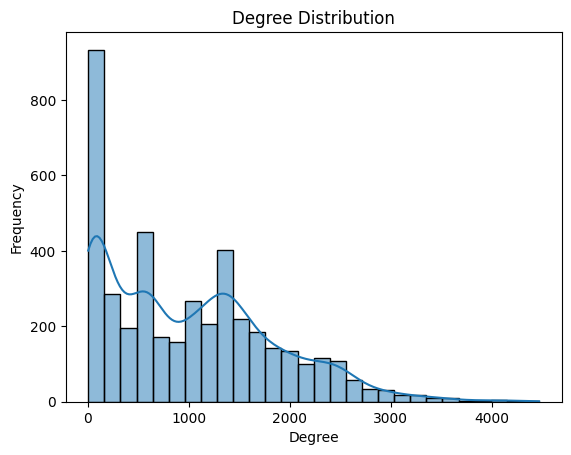

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# bincount counts the occurrences of each degree value
degrees = np.bincount(dataset.graph["edge_index"].flatten())

sns.histplot(degrees, kde=True)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution");

Compute how densely the graph is connected

In [10]:
num_nodes = dataset.graph["num_nodes"]
num_observed_edges = dataset.graph["edge_index"].shape[1]

# Since each edge in an undirected graph can be represented in two ways, we
# multiply by 2 to account for the bidirectionality.
num_observed_edges = 2 * num_observed_edges

# For any graph with n nodes, the maximum number of edges (assuming no
# self-loops) is n * (n-1).
num_possible_edges = num_nodes * (num_nodes - 1)

density = num_observed_edges / num_possible_edges

print(
  f"There are {num_observed_edges} observed edges and {num_possible_edges} "
  f"possible edges,\ngiving a graph density of {round(density, 2)}."
)

There are 4271644 observed edges and 18203022 possible edges,
giving a graph density of 0.23.


In [11]:
data_split = dataset.get_edge_split()
data_split

/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:138: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  train = torch.load(osp.join(path, 'train.pt'))
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  valid = torch.load(osp.join(path, 'valid.pt'))
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:140: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  test = torch.load(osp.join(path, 'test.pt'))


{'train': {'edge': array([[4039, 2424],
         [4039,  225],
         [4039, 3901],
         ...,
         [ 647,  708],
         [ 708,  338],
         [ 835, 3554]])},
 'valid': {'edge': array([[ 722,  548],
         [ 874, 3436],
         [ 838, 1587],
         ...,
         [3661, 3125],
         [3272, 3330],
         [1330,  776]]),
  'edge_neg': array([[   0,   58],
         [   0,   84],
         [   0,   90],
         ...,
         [4162, 4180],
         [4168, 4260],
         [4180, 4221]])},
 'test': {'edge': array([[2198, 1172],
         [1205,  719],
         [1818, 2866],
         ...,
         [ 326, 1109],
         [ 911, 1250],
         [4127, 2480]]),
  'edge_neg': array([[   0,    2],
         [   0,   16],
         [   0,   42],
         ...,
         [4168, 4259],
         [4208, 4245],
         [4245, 4259]])}}

Here, notice that both valid and neg set includes a "neg" counterpart representing unconnected edges (for performance evaluation).

In [12]:
print(
  f'Number of edges in train set: {data_split["train"]["edge"].shape[0]}\n'
  f'Number of edges in valid set: {data_split["valid"]["edge"].shape[0]}\n'
  f'Number of edges in test set: {data_split["test"]["edge"].shape[0]}'
)

Number of edges in train set: 1067911
Number of edges in valid set: 133489
Number of edges in test set: 133489


Check if all nodes are presented in training set (aka transductive learning instead of inductive learning)

In [13]:
train_nodes = np.unique(data_split["train"]["edge"])
valid_nodes = np.unique(data_split["valid"]["edge"])
test_nodes = np.unique(data_split["test"]["edge"])

# Check if all nodes in valid and test sets are present in train set.
valid_in_train = np.isin(valid_nodes, train_nodes).all()
test_in_train = np.isin(test_nodes, train_nodes).all()

print(f"All validation nodes are in training nodes: {valid_in_train}")
print(f"All test nodes are in training nodes: {test_in_train}")

All validation nodes are in training nodes: True
All test nodes are in training nodes: True


### 4.3.3. Examining Drug Names


In [14]:
import pandas as pd

ddi_descriptions = pd.read_csv(
  assets("graphs/datasets/ogbl_ddi/mapping/ddi_description.csv.gz")
)
print(ddi_descriptions)

        first drug id   first drug name second drug id  \
0             DB00001         Lepirudin        DB06605   
1             DB00001         Lepirudin        DB06695   
2             DB00001         Lepirudin        DB01254   
3             DB00001         Lepirudin        DB01609   
4             DB00001         Lepirudin        DB01586   
...               ...               ...            ...   
2669759       DB15657  Ala-geninthiocin        DB13347   
2669760       DB15657  Ala-geninthiocin        DB13451   
2669761       DB15657  Ala-geninthiocin        DB14055   
2669762       DB15657  Ala-geninthiocin        DB00581   
2669763       DB15657  Ala-geninthiocin        DB14443   

                                        second drug name  \
0                                               Apixaban   
1                                   Dabigatran etexilate   
2                                              Dasatinib   
3                                            Deferasirox   
4  

Look up node indices and drug ID

In [15]:
node_to_dbid_lookup = pd.read_csv(
  assets("graphs/datasets/ogbl_ddi/mapping/nodeidx2drugid.csv.gz")
)
print(node_to_dbid_lookup)

      node idx  drug id
0            0  DB00001
1            1  DB00002
2            2  DB00004
3            3  DB00005
4            4  DB00006
...        ...      ...
4262      4262  DB15595
4263      4263  DB15598
4264      4264  DB15617
4265      4265  DB15623
4266      4266  DB15657

[4267 rows x 2 columns]


In [16]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.min_rows", 100)

Rank the drugs with most numbers of interactions

In [17]:
ddi_descriptions["first drug name"].value_counts().head(10)

first drug name
Quinidine         2477
Chlorpromazine    2431
Desipramine       2345
Amitriptyline     2338
Clozapine         2324
Doxepin           2273
Clomipramine      2269
Haloperidol       2269
Carbamazepine     2267
Imipramine        2260
Name: count, dtype: int64

Build a dataframe that documents node ID with drug ID and name

In [18]:
first_drug = ddi_descriptions[["first drug id", "first drug name"]].rename(
  columns={"first drug id": "dbid", "first drug name": "drug_name"}
)
second_drug = ddi_descriptions.loc[
  :, ["second drug id", "second drug name"]
].rename(columns={"second drug id": "dbid", "second drug name": "drug_name"})
dbid_to_name_lookup = (
  pd.concat([first_drug, second_drug]).drop_duplicates().reset_index(drop=True)
)

drugs_lookup = pd.merge(
  node_to_dbid_lookup.rename(
    columns={"drug id": "dbid", "node idx": "node_id"}
  ),
  dbid_to_name_lookup,
  on="dbid",
  how="inner",
)

drugs_lookup.iloc[935]

node_id            935
dbid           DB01043
drug_name    Memantine
Name: 935, dtype: object

### 4.3.4. Visualizing Graphs


Sample a subgraph from training set and visualized with networkx

In [19]:
import numpy as np

np.random.seed(42)


def get_subgraph(edges: np.ndarray, node_limit: int) -> np.ndarray:
  """Gets a subgraph by sampling nodes and their edges."""
  nodes = np.unique(edges)
  sampled_nodes = np.random.choice(nodes, size=node_limit, replace=False)
  filtered_edges = edges[
    np.isin(edges[:, 0], sampled_nodes) & np.isin(edges[:, 1], sampled_nodes)
  ]
  print(f"Subgraph has {filtered_edges.shape[0]} edges")
  return filtered_edges


# Sample 50 nodes from the training set.
subgraph = get_subgraph(node_limit=50, edges=data_split["train"]["edge"])

Subgraph has 152 edges


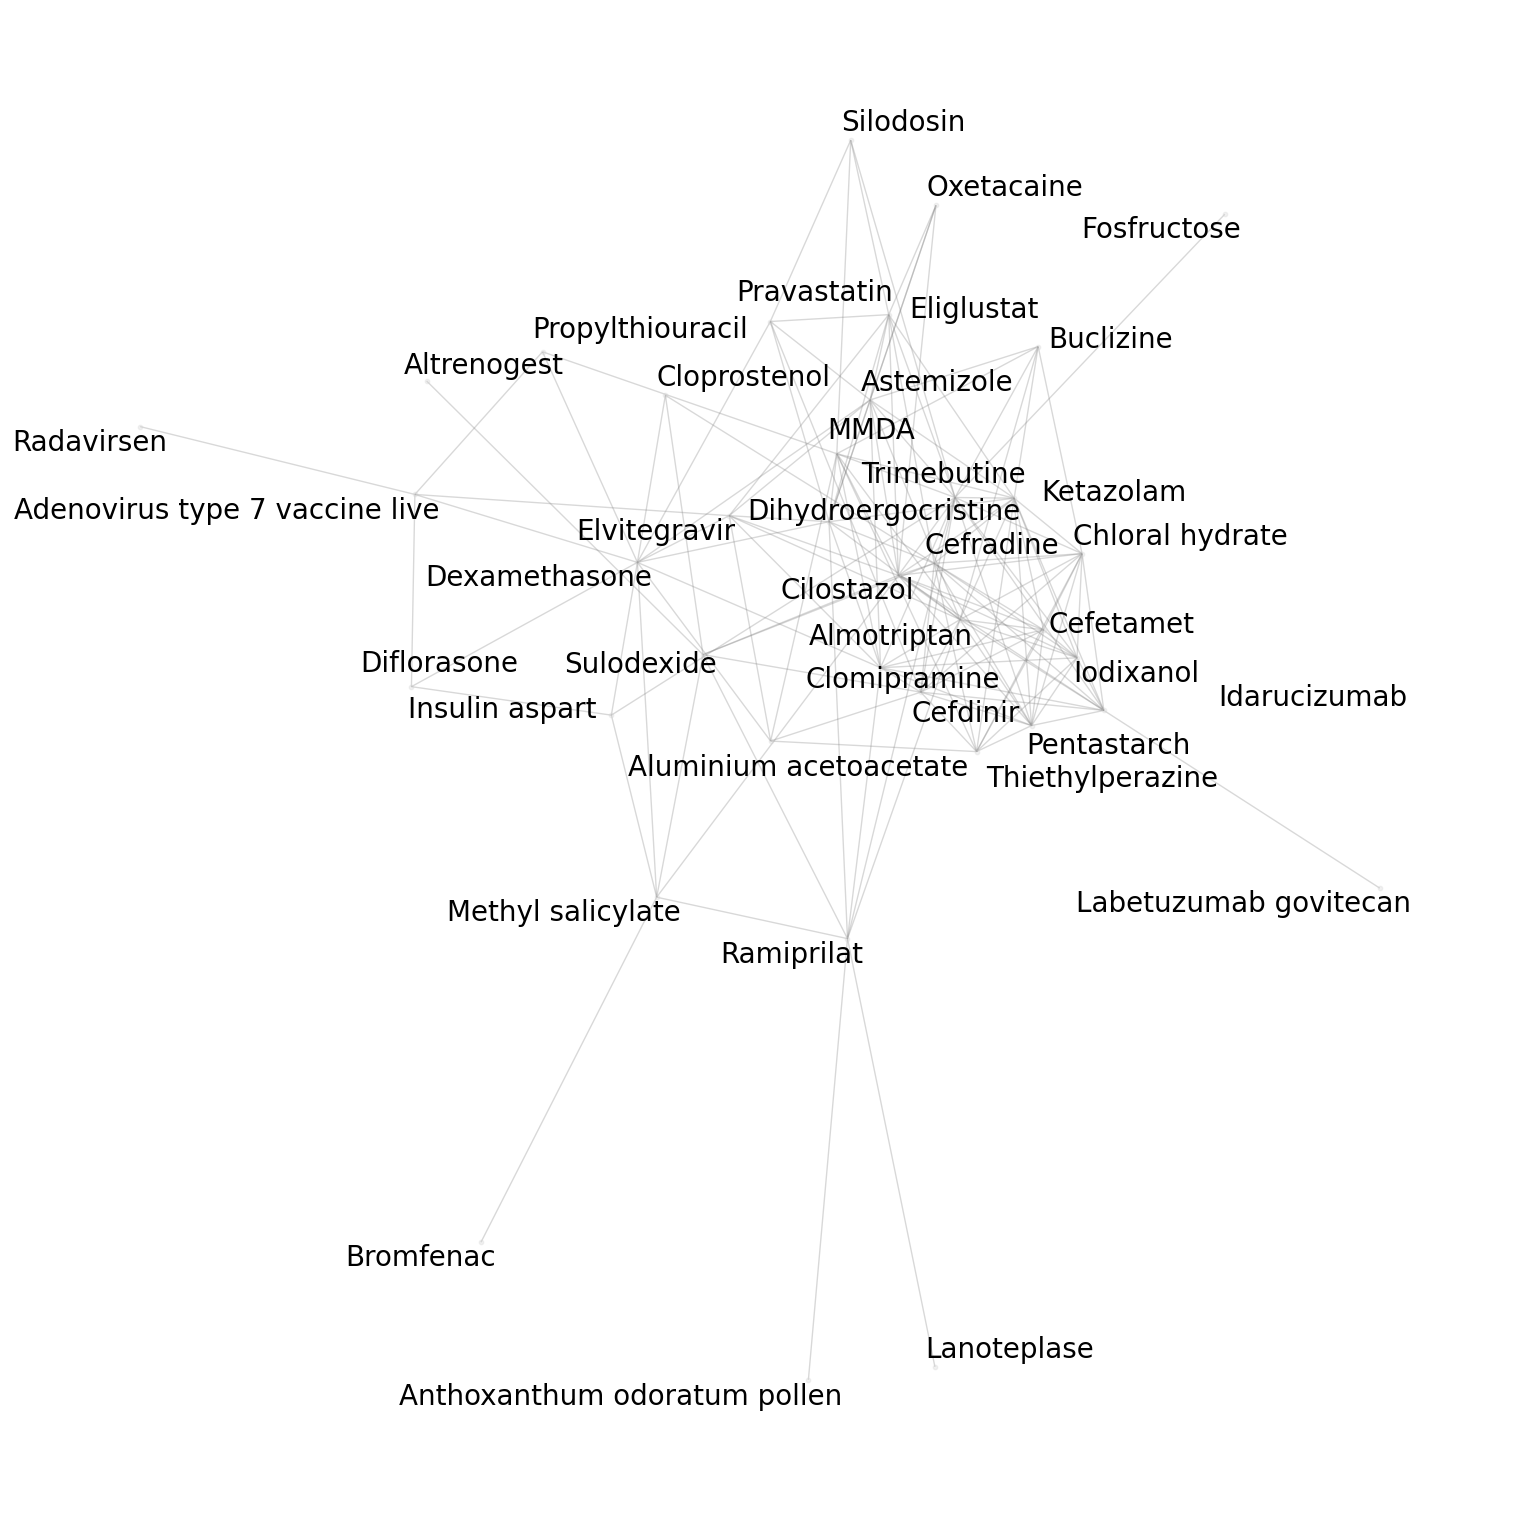

In [20]:
import networkx as nx
from adjustText import adjust_text


def plot_ddi_graph(graph: np.ndarray, drugs_lookup: pd.DataFrame) -> plt.Figure:
  """Plots a drug–drug interaction graph with labeled nodes."""
  fig = plt.figure(figsize=(15, 15))
  G = nx.Graph()
  G.add_edges_from(graph)
  pos = nx.spring_layout(G)
  nx.draw(
    G=G,
    pos=pos,
    with_labels=False,
    node_color="lightgray",
    edge_color="gray",
    node_size=10,
    alpha=0.3,
  )
  names = (
    drugs_lookup[drugs_lookup["node_id"].isin(G.nodes)]
    .set_index("node_id")["drug_name"]
    .to_dict()
  )
  labels = nx.draw_networkx_labels(G=G, pos=pos, labels=names, font_size=20)
  adjust_text(list(labels.values()))
  return fig


plot_ddi_graph(subgraph, drugs_lookup);

## 4.4. Building a Dataset
### 4.4.1. Creating a Dataset Builder


The JAX ecosystem has jraph, a graph library that offers foundational, graph-aware classes and data structures, allowing us to build flexible graph processing models while benefiting from JAX’s speed and efficiency.

In [21]:
from dlfb.graphs.dataset.builder import DatasetBuilder

display([DatasetBuilder.__init__, DatasetBuilder.build])

def __init__(self, path):
    """Initializes the dataset builder with a path to the dataset."""
    self.path = path


  def build(
    self,
    node_limit: int | None = None,
    rng: jax.Array | None = None,
    keep_original_ids: bool = False,
  ) -> dict[str, Dataset]:
    """Builds and returns a dictionary of dataset splits."""
    dataset_splits = {}
    n_nodes, split_pairs = self.download()
    annotation = self.prepare_annotation()

    for name, split in split_pairs.items():
      pos_pairs, neg_pairs = split["edge"], split["edge_neg"]
      graph = self.prepare_graph(n_nodes, pos_pairs)
      pairs = self.prepare_pairs(graph, pos_pairs, neg_pairs)
      dataset_splits.update({name: Dataset(n_nodes, graph, pairs, annotation)})

    if node_limit and (rng is not None):
      dataset_splits = self.subset(
        dataset_splits, rng, node_limit, keep_original_ids
      )

    return dataset_splits

### 4.4.2. Download the Raw Dataset


In [22]:
display([DatasetBuilder.download])

def download(self) -> tuple[int, dict]:
    """Downloads the dataset and returns the number of nodes and edge splits."""
    raw = LinkPropPredDataset(name="ogbl-ddi", root=self.path)
    n_nodes = raw[0]["num_nodes"]
    split_pairs = raw.get_edge_split()
    split_pairs["train"]["edge_neg"] = None  # Placeholder for negative edges.
    return n_nodes, split_pairs

### 4.4.3. Prepare the Annotation


In [23]:
display([DatasetBuilder.prepare_annotation])

def prepare_annotation(self) -> pd.DataFrame:
    """Annotates nodes by mapping node IDs to database IDs and drug names."""
    ddi_descriptions = pd.read_csv(
      f"{self.path}/ogbl_ddi/mapping/ddi_description.csv.gz"
    )
    node_to_dbid_lookup = pd.read_csv(
      f"{self.path}/ogbl_ddi/mapping/nodeidx2drugid.csv.gz"
    )
    # Merge first and second drug descriptions into a single lookup.
    first_drug = ddi_descriptions.loc[
      :, ["first drug id", "first drug name"]
    ].rename(columns={"first drug id": "dbid", "first drug name": "drug_name"})

    second_drug = ddi_descriptions.loc[
      :, ["second drug id", "second drug name"]
    ].rename(
      columns={"second drug id": "dbid", "second drug name": "drug_name"}
    )
    dbid_to_name_lookup = (
      pd.concat([first_drug, second_drug])
      .drop_duplicates()
      .reset_index(drop=True)
    )

    # Merge with node-to-DBID lookup.
    annotation = pd.merge(
      node_to_dbid_lookup.rename(
        columns={"drug id": "dbid", "node idx": "node_id"}
      ),
      dbid_to_name_lookup,
      on="dbid",
      how="inner",
    )
    return annotation

### 4.4.4. Prepare the Graph


In [24]:
display([DatasetBuilder.prepare_graph])
# by default, jraph doesn't explicitly make undirected graphs, so we need to do it ourselves by 
# symmetrizing the senderes and receivers

# parameter globals would be used for storing graph-level features

def prepare_graph(
    self, n_nodes: int, pos_pairs: jax.Array
  ) -> jraph.GraphsTuple:
    """Prepares a Jraph graph from positive edge pairs."""
    senders, receivers = self.make_undirected(pos_pairs[:, 0], pos_pairs[:, 1])
    graph = jraph.GraphsTuple(
      nodes={"gid": jnp.arange(n_nodes)},  # Optional global node ID.
      edges=None,
      senders=senders,
      receivers=receivers,
      n_node=jnp.array([n_nodes]),
      n_edge=jnp.array([len(senders)]),
      globals=None,
    )
    return graph

In [25]:
display([DatasetBuilder.make_undirected])

@staticmethod
  def make_undirected(
    senders: jax.Array, receivers: jax.Array
  ) -> tuple[jax.Array, jax.Array]:
    """Makes an undirected graph by duplicating edges in both directions."""
    # Jraph requires undirected graphs to have both A->B and B->A edges
    # explicitly.
    senders_undir = jnp.concatenate((senders, receivers))
    receivers_undir = jnp.concatenate((receivers, senders))
    return senders_undir, receivers_undir

### 4.4.5. Prepare the Pairs


we use the prepare_pairs method to obtain the drug–drug pairs—both positive and negative—that the model will classify as either connected or not.

In [26]:
display([DatasetBuilder.prepare_pairs])

def prepare_pairs(
    self, graph: int, pos_pairs: jax.Array, neg_pairs: jax.Array | None = None
  ) -> Pairs:
    """Prepares positive and negative edge pairs."""
    if neg_pairs is None:
      neg_pairs = self.infer_negative_pairs(graph)
    return Pairs(pos=pos_pairs, neg=neg_pairs)

Generate negative pairs for training set (valid and test neg sets were already provided by the ddi bank)

In [27]:
display([DatasetBuilder.infer_negative_pairs])

def infer_negative_pairs(self, graph: jraph.GraphsTuple) -> jax.Array:
    """Infers negative edge pairs in a graph."""
    # Initialize a matrix where all possible edges are marked as potential
    # negative edges (1).
    neg_adj_mask = np.ones((graph.n_node[0], graph.n_node[0]), dtype=np.uint8)

    # Mask out existing edges in the graph (set to 0).
    neg_adj_mask[graph.senders, graph.receivers] = 0

    # Use the upper triangular part of the matrix to avoid duplicate pairs and
    # self-loops.
    neg_adj_mask = np.triu(neg_adj_mask, k=1)
    neg_pairs = jnp.array(neg_adj_mask.nonzero()).T  # Extract indices.
    return neg_pairs

Notice that neg pairs can easily outnumber pos pairs with this type of inference. Therefore for later training, we have to further subset the neg pairs.

### 4.4.6. Subsetting the Graph


Select a subset of nodes based on a specified node_limit and apply this subset consistently across all dataset splits (i.e., training, validation, test).

In [28]:
display([DatasetBuilder.subset])

def subset(
    self,
    dataset_splits: dict[str, Dataset],
    rng: jax.Array,
    node_limit: int,
    keep_original_ids: bool = False,
  ) -> dict[str, Dataset]:
    """Creates subset of dataset splits by sampling a fixed number of nodes."""
    # Get a random subset of node_ids.
    node_ids = jax.random.choice(
      rng, dataset_splits["train"].n_nodes, (node_limit,), replace=False
    )

    # Subset every dataset split by the same node_ids.
    dataset_subset_splits = {}
    for name, dataset in dataset_splits.items():
      dataset_subset_splits[name] = dataset.subset(node_ids, keep_original_ids)

    return dataset_subset_splits

### 4.4.7. The Dataset Class


In [29]:
import re

from dlfb.graphs.dataset import Dataset

display([re.split(r"\n\s+def\s", inspect.getsource(Dataset))[0]])

@dataclass
class Dataset:
  """Graph dataset with nodes, pairs, and optional annotations."""

  n_nodes: int
  graph: jraph.GraphsTuple
  pairs: Pairs
  annotation: pd.DataFrame = field(default_factory=pd.DataFrame)

## 4.5. Building a Prototype

Model components: 
- Neighborhood encoding: Generates node embeddings that reflect the local graph structure
- Link prediction: Uses these embeddings to score the likelihood of a connection between node pairs

Training components: 
- Negative sampling: Selects unconnected node pairs to contrast with true edges 
- Loss function: Computes the training signal to optimize model performance

### 4.5.1. Node Encoder


In a transductive learning settings in which we want to predict edge existance among known nodes based on connectivity information, we initialized first-layer node embeddings randomly as "LEARNABLE PARAMETERS". Supposely after training the model can find optimized embedding features for each nodes.

In [30]:
from dlfb.graphs.model import NodeEncoder

display([NodeEncoder])
# GraphSAGE-inspired implementation, as further explained below
# The two-layer design allows model to capture features from both immediate neighbors and neighbors two hops away

class NodeEncoder(nn.Module):
  """Encodes nodes into embeddings using a two-layer GraphSAGE model."""

  n_nodes: int
  embedding_dim: int
  last_layer_self: bool
  degree_norm: bool
  dropout_rate: float

  def setup(self):
    """Initializes node embeddings, which cover the full graph's n_nodes."""
    self.node_embeddings = nn.Embed(
      num_embeddings=self.n_nodes,
      features=self.embedding_dim,
      embedding_init=jax.nn.initializers.glorot_uniform(),
    )

  @nn.compact
  def __call__(self, graph: jraph.GraphsTuple, is_training: bool) -> jax.Array:
    """Encodes the nodes of a graph into embeddings."""
    # Graph can be a subgraph and thus we use a subset of embeddings
    x = self.node_embeddings(graph.nodes["gid"])

    # First convolutional layer.
    x = SAGEConv(
      self.embedding_dim, with_self=True, degree_norm=self.degree_norm
    )(graph, x)
    x = nn.relu(x)
    x = nn.Dropout(rate=self.dropout_rate, deterministic=not is_training)(x)

    # Second convolutional layer.
    x = SAGEConv(
      self.embedding_dim,
      with_self=self.last_layer_self,
      degree_norm=self.degree_norm,
    )(graph, x)

    return x

### 4.5.2. Graph Convolution


For each receiver node, a SAGEConv performs:
- (Optional) Self-loop to include receiver node embeddings
- Embedding aggregation from neighboring nodes (mean with optional sender degree normalization)
- Skip connection (concatenation) to preserve receiver node embeddings
- Fully connected layer (nn.Dense) to perform linear transformation (dim: 2xembed_dim -> embed_dim)

Dropout mechanism and activation function (non-linear transformation) are performed externally if needed.

In [31]:
from dlfb.graphs.model import SAGEConv

display([SAGEConv])
# with_self: allow adding self-loops to the graph, to incorporate a node's own features during aggregation
# degree_norm: normalize by node degree to prevent bias toward high-degree node contributions
# - DN is done in a "symmetric", in which
#   messages are scaled by 1/sqrt(degree_sender) during sending
#   and by 1/sqrt(degree_receiver) during receiving

# the embedding of a node is preserved in two ways:
# 1. Adding self-edge (self-loops) via with_self=True
# 2. Skip connection by concatenating the node's own features with the aggregated neighbor features with combined_embeddings = jnp.concatenate([node_features, aggregated_neighbors], axis=-1)
# (page 40 of Maria's slide)

# nn.Dense(self.embedding_dim)(combined_embeddings) inputs the concatenated features and projects them to the desired embedding dimension
# input dim: 2 * node feature dim (due to concatenation)
# output dim: embedding dim

class SAGEConv(nn.Module):
  """GraphSAGE convolutional layer with optional self-loops."""

  embedding_dim: int
  with_self: bool
  degree_norm: bool

  @nn.compact
  def __call__(self, graph: jraph.GraphsTuple, x) -> jax.Array:
    n_nodes = self.get_n_nodes(graph)

    # Add self-loops if enabled.
    if self.with_self:
      senders, receivers = self._add_self_edges(graph, n_nodes)
    else:
      senders, receivers = graph.senders, graph.receivers

    # Aggregate node features from neighbors.
    if not self.degree_norm:
      x_updated = jraph.segment_mean(
        x[senders], receivers, num_segments=n_nodes
      )
    else:

      def get_degree(n):
        return jax.ops.segment_sum(jnp.ones_like(senders), n, n_nodes)

      x_updated = self.normalize_by_degree(x, get_degree(senders))
      x_updated = jraph.segment_mean(
        x_updated[senders], receivers, num_segments=n_nodes
      )
      x_updated = self.normalize_by_degree(x_updated, get_degree(receivers))

    # Combine node and neighbor embeddings by concatenation.
    combined_embeddings = jnp.concatenate([x, x_updated], axis=-1)

    return nn.Dense(self.embedding_dim)(combined_embeddings)

  @staticmethod
  def _add_self_edges(
    graph: jraph.GraphsTuple, n_nodes: int
  ) -> tuple[jax.Array, jax.Array]:
    """Adds self-loops to the graph."""
    all_nodes = jnp.arange(n_nodes)
    senders = jnp.concatenate([graph.senders, all_nodes])
    receivers = jnp.concatenate([graph.receivers, all_nodes])
    return senders, receivers

  @staticmethod
  def normalize_by_degree(x: jax.Array, degree: jax.Array) -> jax.Array:
    """Normalizes node features by the square root of the degree."""
    # We set the the degree to a minimum of 1.
    return x * jax.lax.rsqrt(jnp.maximum(degree, 1.0))[:, None]

  @staticmethod
  def get_n_nodes(graph):
    """Returns the number of nodes in the graph in a jittable way."""
    return tree.tree_leaves(graph.nodes)[0].shape[0]

#### 4.5.2.1. Adding Self Edges
#### 4.5.2.2. Aggregating the Neighborhood
#### 4.5.2.3. Normalizing by Degree
#### 4.5.2.4. Combining Embeddings with Neighborhoods
### 4.5.3. Link Prediction


Let's say the model is trained and now the high-level node embeddings capture the graph's structure. We hereby use the LinkPredictor Module to predict scores for true edges (pos) and unrelated node pairs (neg).

The module performs:
- Element-wise multiplication of sender and receiver embeddings, creating a vector representing embedding association. (page 41 of Maria's slide)
- MLP on top of embedding association vector, scoring the probability of new edge existance.

In [32]:
from dlfb.graphs.model import LinkPredictor

display([LinkPredictor])

class LinkPredictor(nn.Module):
  """Predicts interaction scores for pairs of node embeddings."""

  embedding_dim: int
  n_layers: int
  dropout_rate: float

  @nn.compact
  def __call__(
    self,
    sender_embeddings: jax.Array,
    receiver_embeddings: jax.Array,
    is_training: bool,
  ) -> jax.Array:
    """Computes scores for node pairs."""
    x = sender_embeddings * receiver_embeddings  # Element-wise multiplication.

    # Apply MLP layers with ReLU activation and dropout.
    for _ in range(self.n_layers)[:-1]:
      x = nn.Dense(self.embedding_dim)(x)
      x = nn.relu(x)
      x = nn.Dropout(self.dropout_rate, deterministic=not is_training)(x)

    # Final output layer is a single neuron. Logit output used for binary link
    # classification.
    x = nn.Dense(1)(x)

    return jnp.squeeze(x)

### 4.5.4. Drug–Drug Interaction Model


Now we put everything together: NodeEncoder, GraphSAGE block, and LinkPredictor head.

In [33]:
from dlfb.graphs.model import DdiModel

display([DdiModel])
# the class is compatible to both training and inference modes

class DdiModel(nn.Module):
  """Graph-based model for predicting drug-drug interactions (DDIs)."""

  n_nodes: int
  embedding_dim: int
  dropout_rate: float
  last_layer_self: bool
  degree_norm: bool
  n_mlp_layers: int = 2

  def setup(self):
    """Initializes the node encoder and link predictor modules."""
    self.node_encoder = NodeEncoder(
      self.n_nodes,
      self.embedding_dim,
      self.last_layer_self,
      self.degree_norm,
      self.dropout_rate,
    )
    self.link_predictor = LinkPredictor(
      self.embedding_dim, self.n_mlp_layers, self.dropout_rate
    )

  def __call__(
    self,
    graph: jraph.GraphsTuple,
    pairs: dict,
    is_training: bool,
    is_pred: bool = False,
  ):
    """Generates interaction scores for node pairs."""
    # Compute node embeddings. The 'h' stands for hidden state or embedding.
    h = self.node_encoder(graph, is_training)

    if is_pred:
      scores = self.link_predictor(h[pairs[:, 0]], h[pairs[:, 1]], False)

    else:
      pos_senders, pos_receivers = pairs["pos"][:, 0], pairs["pos"][:, 1]
      neg_senders, neg_receivers = pairs["neg"][:, 0], pairs["neg"][:, 1]
      scores = {
        "pos": self.link_predictor(
          h[pos_senders], h[pos_receivers], is_training
        ),
        "neg": self.link_predictor(
          h[neg_senders], h[neg_receivers], is_training
        ),
      }
    return scores

  def create_train_state(self, rng: jax.Array, dummy_input, tx) -> TrainState:
    """Initializes the training state with model parameters."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, is_training=False, **dummy_input)
    return TrainState.create(
      apply_fn=self.apply, params=variables["params"], tx=tx, key=rng_dropout
    )

  @staticmethod
  def add_mean_embedding(embeddings: jax.Array) -> jax.Array:
    """Concatenates a mean embedding to the existing embeddings."""
    mean_embeddings = jnp.mean(embeddings, axis=0, keepdims=True)
    embeddings = jnp.concatenate([embeddings, mean_embeddings], axis=0)
    return embeddings

## 4.6. Training the Model
### 4.6.1. Create a Manageable Dataset


Use 500 nodes as demonstration

In [34]:
import jax

node_limit = 500
rng = jax.random.PRNGKey(42)
rng, rng_dataset = jax.random.split(rng, 2)

dataset_splits = DatasetBuilder(path=assets("graphs/datasets")).build(
  node_limit, rng_dataset
)

/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:67: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.graph = torch.load(pre_processed_file_path, 'rb')
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:138: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  train = torch.load(osp.join(path, 'train.pt'))
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  valid = torch.load(osp.join(path, 'valid.pt'))
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:140: UserWarning

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

In [39]:
dataset_splits.keys()

dict_keys(['train', 'valid', 'test'])

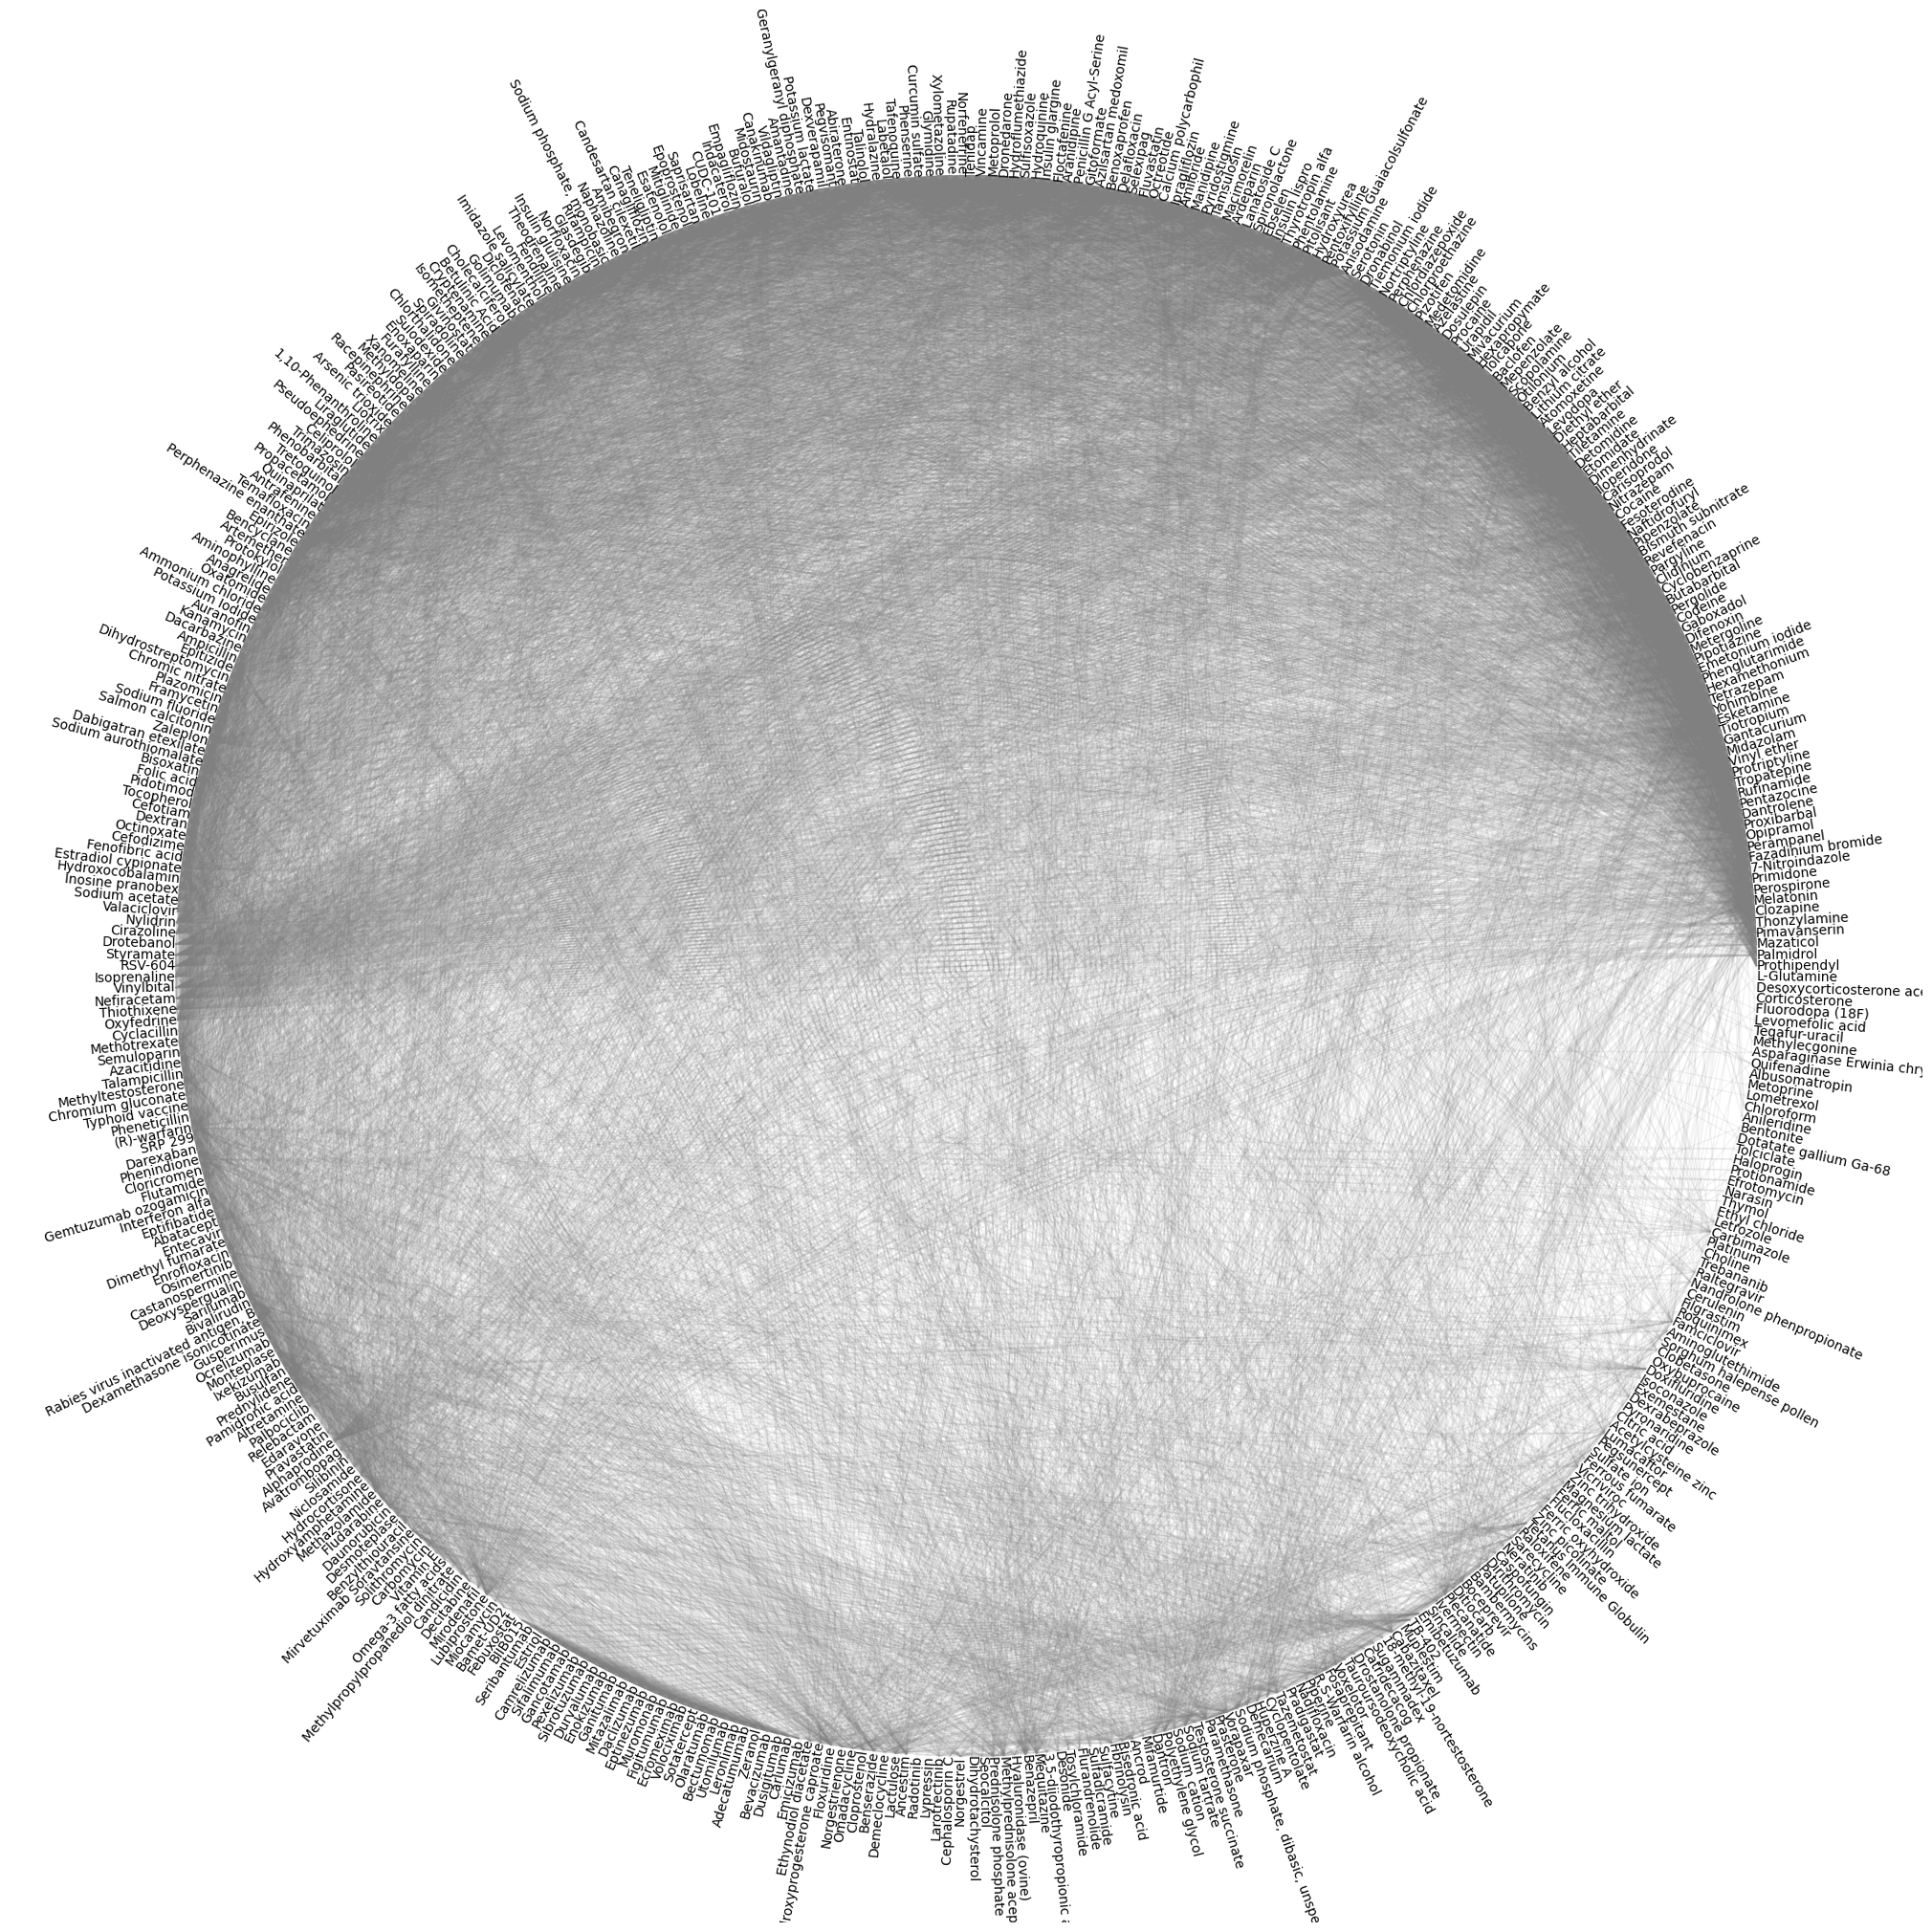

In [36]:
from dlfb.graphs.inspect import plot_graph

plot_graph(dataset_splits["train"]);

### 4.6.2. The Training Loop


Train() performs:
- MetricsLogger initialization and batch_size estimation
- For each epoch
  - Input data pairs by pairs (do prediction to identify edge existence, either positive or negative) in batch.
  - Compute loss and gradient (with MLP dropout), update params in nn.Dense as well as the node embeddings.
  - In the meantime for every given steps, test the model on validation set and update metrics statistics.

In [42]:
from dlfb.graphs.train import train

display([train])
# optional loss function
# optional loss normalization over batch size
# restorable training state with checkpoints

@restorable
def train(
  state: TrainState,
  rng: jax.Array,
  dataset_splits: dict[str, Dataset],
  num_epochs: int,
  loss_fn: Callable,
  norm_loss: bool = False,
  eval_every: int = 10,
) -> tuple[TrainState, dict[str, dict[str, list[dict[str, float]]]]]:
  """Training loop for the drug-drug interaction model."""
  # Initialize metrics and estimate optimal batch sizes.
  metrics = MetricsLogger()
  batch_size = optimal_batch_size(dataset_splits)

  # Epochs with progress bar.
  epochs = tqdm(range(num_epochs))
  for epoch in epochs:
    epochs.set_description(f"Epoch {epoch + 1}")
    rng, rng_shuffle, rng_sample = jax.random.split(rng, 3)

    # Training loop.
    for pairs_batch in dataset_splits["train"].pairs.get_train_batches(
      batch_size, rng_shuffle, rng_sample
    ):
      rng, rng_dropout = jax.random.split(rng, 2)
      state, batch_metrics = train_step(
        state,
        dataset_splits["train"].graph,
        pairs_batch,
        rng_dropout,
        loss_fn,
        norm_loss,
      )
      metrics.log_step(split="train", **batch_metrics)

    # Evaluation loop.
    if epoch % eval_every == 0:
      for pairs_batch in dataset_splits["valid"].pairs.get_eval_batches(
        batch_size
      ):
        batch_metrics = eval_step(
          state, dataset_splits["valid"].graph, pairs_batch, loss_fn, norm_loss
        )
        metrics.log_step(split="valid", **batch_metrics)

    metrics.flush(epoch=epoch)
    epochs.set_postfix_str(metrics.latest(["hits@20"]))

  return state, metrics.export()

### 4.6.3. The Pairs Class


- `get_eval_batches` returns balanced pos and neg pairs for evaluation.
- `get_train_batches` returns shuffled pos and neg pairs for training.
- `get_dummy_input` returns mini-batch for model params initialization.

In [45]:
from dlfb.graphs.dataset import Pairs

display([Pairs])

@dataclass
class Pairs:
  """Represents positive and negative pairs of drug-drug interactions."""

  pos: jax.Array
  neg: jax.Array

  def get_eval_batches(
    self, batch_size: int
  ) -> Generator[dict[str, jax.Array], None, None]:
    """Generates evaluation batches of positive and negative pairs."""
    indices = jnp.arange(self._n_pairs())
    for i in range(self._n_batches(batch_size)):
      batch_indices = jnp.array(indices[i * batch_size : (i + 1) * batch_size])
      yield Pairs(
        pos=self.pos[batch_indices], neg=self.neg[batch_indices]
      ).to_dict()

  def _n_batches(self, batch_size: int) -> int:
    """Calculates number of batches in the dataset given a batch size."""
    return int(np.floor(self._n_pairs() / batch_size))

  def _n_pairs(self) -> int:
    """Returns the smaller number of positive or negative pairs."""
    return int(min(self.pos.shape[0], self.neg.shape[0]))

  def get_train_batches(
    self, batch_size: int, rng_shuffle: jax.Array, rng_sample: jax.Array
  ) -> Generator[dict[str, jax.Array], None, None]:
    """Generates shuffled training batches with sampled negative pairs."""
    # Shuffle indices for positive pairs.
    indices = jax.random.permutation(rng_shuffle, jnp.arange(self._n_pairs()))

    # Get sample of negative pairs.
    neg_sample = self._global_negative_sampling(rng_sample)

    for i in range(self._n_batches(batch_size)):
      batch_indices = jnp.array(indices[i * batch_size : (i + 1) * batch_size])
      yield Pairs(
        pos=self.pos[batch_indices], neg=neg_sample[batch_indices]
      ).to_dict()

  def _global_negative_sampling(self, rng_sample: jax.Array) -> jax.Array:
    """Samples negative pairs from the entire set to match positive set size."""
    return jax.random.choice(
      rng_sample, self.neg, (self.pos.shape[0],), replace=False
    )

  def get_dummy_input(self) -> dict[str, jax.Array]:
    """Returns a small dummy subset of positive and negative pairs."""
    return Pairs(pos=self.pos[:2], neg=self.neg[:(2)]).to_dict()

  def to_dict(self) -> dict:
    """Converts the Pairs object back to a dictionary."""
    return {"pos": self.pos, "neg": self.neg}

#### 4.6.3.1. Batching by Pairs


In [46]:
from dlfb.graphs.train import optimal_batch_size

display([optimal_batch_size])

def optimal_batch_size(
  dataset_splits: dict[str, Dataset], remainder_tolerance: float = 0.125
) -> int:
  """Calculates optimal batch size for optimizing JAX compilation."""
  # Calculate the minimum length of positive and negative pairs for each
  # dataset.
  lengths = [
    min(dataset.pairs.pos.shape[0], dataset.pairs.neg.shape[0])
    for dataset in dataset_splits.values()
  ]

  # Determine the allowable remainders per split based on the remainder
  # tolerance.
  remainder_thresholds = [
    int(length * remainder_tolerance) for length in lengths
  ]
  max_possible_batch_size = min(lengths)

  for batch_size in range(max_possible_batch_size, 0, -1):
    remainders = [length % batch_size for length in lengths]
    if all(
      remainder <= threshold
      for remainder, threshold in zip(remainders, remainder_thresholds)
    ):
      return batch_size
  return max_possible_batch_size

#### 4.6.3.2. Sampling Negative Pairs


In [10]:
display([Pairs._global_negative_sampling])

def _global_negative_sampling(self, rng_sample: jax.Array) -> jax.Array:
    """Samples negative pairs from the entire set to match positive set size."""
    return jax.random.choice(
      rng_sample, self.neg, (self.pos.shape[0],), replace=False
    )

The subset of negative samples can significantly impact training. In this implementation, we use the simplest approach: global sampling, where we uniformly sample from all possible negative pairs. This strategy is suitable when we are broadly interested in potential node connections across the entire graph.

Other negative pairs selection strategies are also possible:
- Local sampling (focus on one nodes)
- Hard negative sampling (focus on failures, aka false positives)
- Adversarial negative sampling (second model challenging the predictor model)
- Skewing the pos:neg ratio

### 4.6.4. Create the Train Step Function


If norm_loss=True, the total loss is divided by the number of training pairs in the batch (positive + negative), ensuring that loss magnitudes remain comparable across different batch sizes or sampling ratios.

In [47]:
from dlfb.graphs.train import train_step

display([train_step])
# the @partial decorator allows loss_fn and norm_loss to be static and pass through the jit compilation

@partial(jax.jit, static_argnames=["loss_fn", "norm_loss"])
def train_step(
  state: TrainState,
  graph: jraph.GraphsTuple,
  pairs: dict[str, jax.Array],
  rng_dropout: jax.Array,
  loss_fn: Callable = binary_log_loss,
  norm_loss: bool = False,
) -> tuple[TrainState, dict[str, jax.Array]]:
  """Performs a single training step, updating model parameters."""

  def calculate_loss(params):
    """Computes loss and hits@20 metric for the given model parameters."""
    scores = state.apply_fn(
      {"params": params},
      graph,
      pairs,
      is_training=True,
      rngs={"dropout": rng_dropout},
    )
    loss = loss_fn(scores)
    metric = evaluate_hits_at_20(scores)
    return loss, metric

  # to additional variables (e.g., state, graph, pairs) without requiring them
  # to be explicitly passed, while maintaining compatibility with
  # jax.value_and_grad.
  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (loss, metric), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)

  metrics = {"loss": loss, "hits@20": metric}
  if norm_loss:
    metrics["loss"] = metrics["loss"] / (
      pairs["pos"].shape[0] + pairs["neg"].shape[0]
    )

  return state, metrics

In [51]:
from dlfb.graphs.train import binary_log_loss

display([binary_log_loss])

# clip the value within (0, 1) instead of [0, 1] to avoid log(0) issues

@jax.jit
def binary_log_loss(scores: dict[str, jax.Array]) -> jax.Array:
  """Computes the binary log loss for positive and negative drug pairs."""
  # Clip probabilities to avoid numerical instability.
  probs = jax.tree.map(
    lambda x: jnp.clip(nn.sigmoid(x), 1e-7, 1 - 1e-7), scores
  )

  # Compute positive and negative losses.
  pos_loss = -jnp.log(probs["pos"]).mean()
  neg_loss = -jnp.log(1 - probs["neg"]).mean()

  return pos_loss + neg_loss

### 4.6.5. Create the Evaluation Metric


In [49]:
from dlfb.graphs.train import eval_step

display([eval_step])

@partial(jax.jit, static_argnames=["loss_fn", "norm_loss"])
def eval_step(
  state: TrainState,
  graph: jraph.GraphsTuple,
  pairs: dict[str, jax.Array],
  loss_fn: Callable = binary_log_loss,
  norm_loss: bool = False,
) -> dict[str, jax.Array]:
  """Performs an evaluation step, computing loss and hits@20 metric."""
  scores = state.apply_fn(
    {"params": state.params}, graph, pairs, is_training=False
  )
  metrics = {"loss": loss_fn(scores), "hits@20": evaluate_hits_at_20(scores)}
  if norm_loss:
    metrics["loss"] = metrics["loss"] / (
      pairs["pos"].shape[0] + pairs["neg"].shape[0]
    )

  return metrics

Hits@20 evaluates how well the model ranks positive node pairs compared to negative ones, giving an intuitive signal of ranking quality. Specifically, it identifies the 20th highest score among the negative pairs as a threshold and calculates the proportion of positive scores that exceed this threshold; then it calculates the proportion of positive scores that exceeds this threshold.

In [52]:
from dlfb.graphs.train import evaluate_hits_at_20

display([evaluate_hits_at_20])

@jax.jit
def evaluate_hits_at_20(scores: dict[str, jax.Array]) -> jax.Array:
  """Computes the hits@20 metric capturing positive pairs ranking."""
  # Implementation inspired by the OGB benchmark: https://github.com/snap-stanford/ogb/blob/f631af76359c9687b2fe60905557bbb241916258/ogb/linkproppred/evaluate.py#L214
  # Find the 20th highest score among negative edges.
  kth_score_in_negative_edges = jnp.sort(scores["neg"])[-20]

  # Compute the proportion of positive scores greater than the threshold.
  return (
    jnp.sum(scores["pos"] > kth_score_in_negative_edges)
    / scores["pos"].shape[0]
  )

### 4.6.6. Train the Simplest Model


In [53]:
import optax

rng, rng_init, rng_train = jax.random.split(rng, 3)

model = DdiModel(
  n_nodes=dataset_splits["train"].n_nodes,
  embedding_dim=128,
  last_layer_self=False,
  degree_norm=False,
  dropout_rate=0.3,
)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input={
      "graph": dataset_splits["train"].graph,
      "pairs": dataset_splits["train"].pairs.get_dummy_input(),
    },
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=500,
  eval_every=1,
  loss_fn=binary_log_loss,
  norm_loss=False,
  store_path=assets("graphs/models/initial_model"),
)

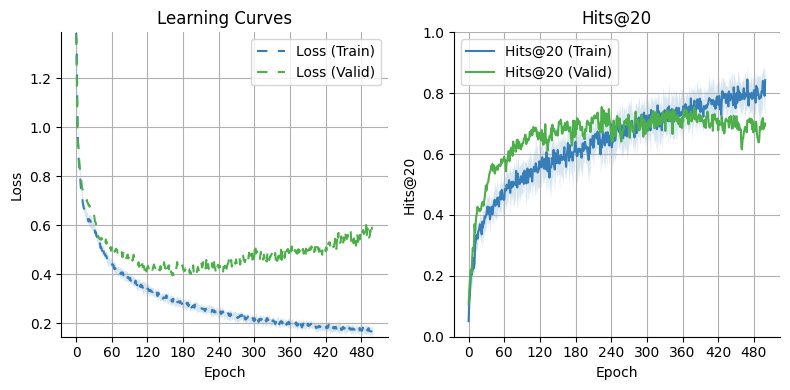

In [54]:
from dlfb.graphs.inspect import plot_learning

plot_learning(metrics);

## 4.7. Improving the Model
### 4.7.1. Change to AUC Loss


Inspired by a paper on pairwise learning for neural link prediction (PLNLP),7 which outlines key stages of a link prediction pipeline, we will swap the loss function to better align with our objective. Instead of focusing on binary classifications, we adopt a ranking-based approach that encourages the model to score connected pairs higher than unconnected ones, aligning conceptually with the area under the curve (AUC) metric.

AUC measures the probability that a randomly chosen positive instance (connected node pair) has a higher score than a randomly chosen negative instance (nonconnected pair). While directly optimizing AUC would be ideal, it is computationally challenging because its gradients are often undefined or zero. To address this, we use a surrogate loss function that mimics AUC’s properties while remaining easy to optimize.

A simple and effective surrogate is the squared loss, which penalizes deviations from the target score difference of 1 between positive and negative pairs. This means the model is penalized both when the difference is less than 1 (underestimation) and when it is greater than 1 (overestimation).

In [55]:
from dlfb.graphs.train import auc_loss

display([auc_loss])

@jax.jit
def auc_loss(scores: dict[str, jax.Array]) -> jax.Array:
  """Computes AUC-based loss for positive and negative drug pairs."""
  return jnp.square(1 - (scores["pos"] - scores["neg"])).sum()

Now initialize a new model with AUC loss (surrogate version) (already trained)

In [57]:
rng, rng_init, rng_train = jax.random.split(rng, 3)

model = DdiModel(
  n_nodes=dataset_splits["train"].n_nodes,
  embedding_dim=128,
  last_layer_self=False,
  degree_norm=False,
  dropout_rate=0.3,
)

_, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input={
      "graph": dataset_splits["train"].graph,
      "pairs": dataset_splits["train"].pairs.get_dummy_input(),
    },
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=500,
  eval_every=1,
  loss_fn=auc_loss,
  norm_loss=True,
  store_path=assets("graphs/models/initial_model_auc"),
)

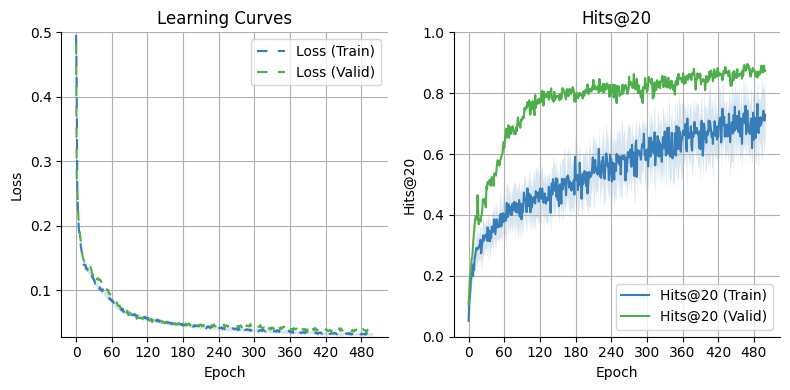

In [58]:
plot_learning(metrics);

Aligning the objective with our ranking metric directly translates into better and more reliable performance.

### 4.7.2. Set Model Sweeping and Training Parameters
#### 4.7.2.1. Varying Embedding Dimensions


Sweep embedding dimensions from 64 to 512.

In [59]:
embedding_dims = [64, 128, 256, 512]

model_params = {
  "n_nodes": dataset_splits["train"].n_nodes,
  "last_layer_self": False,
  "degree_norm": False,
  "dropout_rate": 0.3,
}
training_params = {
  "rng": rng_train,
  "dataset_splits": dataset_splits,
  "num_epochs": 500,
  "eval_every": 25,
  "loss_fn": auc_loss,
  "norm_loss": True,
}

In [60]:
from dlfb.utils.metric_plots import to_df

all_metrics = []

for embedding_dim in embedding_dims:
  model = DdiModel(**{"embedding_dim": embedding_dim, **model_params})
  _, metrics = train(
    state=model.create_train_state(
      rng=rng_init,
      dummy_input={
        "graph": dataset_splits["train"].graph,
        "pairs": dataset_splits["train"].pairs.get_dummy_input(),
      },
      tx=optax.adam(0.001),
    ),
    **training_params,
    store_path=assets(f"graphs/models/sweep_embedding_dim:{embedding_dim}"),
  )

  df = to_df(metrics).assign(**{"embedding_dim": embedding_dim})
  all_metrics.append(df)

all_metrics_df = pd.concat(all_metrics, axis=0)

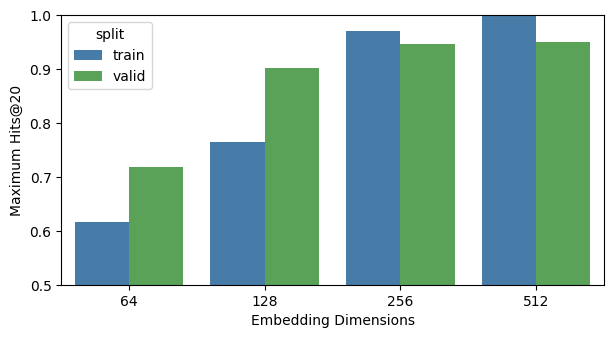

In [61]:
import seaborn as sns
from matplotlib import pyplot as plt

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

data = all_metrics_df
data = data[(data["metric"] == "hits@20")]
data = data.groupby(["metric", "split", "embedding_dim"], as_index=False)[
  "mean"
].max()
data = data.sort_values(by=["split", "mean"])

plt.figure(figsize=(7, 3.5))
sns.barplot(
  data=data,
  x="embedding_dim",
  y="mean",
  hue="split",
  palette=DEFAULT_SPLIT_COLORS,
)
plt.ylim(0.5, 1)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Maximum Hits@20");

#### 4.7.2.2. Varying multiple hyperparameters


We will vary the following parameters: 
- Dropout rate: 0, 0.3, or 0.5
- Self-edges in the last convolutional layer: Whether to include self-edges (last_layer_self: True or False)
- Degree normalization: Whether to normalize node embeddings by their degree (degree_norm: True or False) 
- Number of MLP layers in the link predictor: 1, 2, or 3 (n_mlp_layers)

In [62]:
import itertools

model_params = {
  "n_nodes": dataset_splits["train"].n_nodes,
  "embedding_dim": 512,
}

model_params_sweep = {
  "dropout_rate": [0, 0.3, 0.5],
  "last_layer_self": [True, False],
  "degree_norm": [True, False],
  "n_mlp_layers": [1, 2, 3],
}
keys, values = zip(*model_params_sweep.items())
model_param_combn = [
  dict(zip(keys, combo)) for combo in itertools.product(*values)
]
print(pd.DataFrame(model_param_combn))

    dropout_rate  last_layer_self  degree_norm  n_mlp_layers
0            0.0             True         True             1
1            0.0             True         True             2
2            0.0             True         True             3
3            0.0             True        False             1
4            0.0             True        False             2
5            0.0             True        False             3
6            0.0            False         True             1
7            0.0            False         True             2
8            0.0            False         True             3
9            0.0            False        False             1
10           0.0            False        False             2
11           0.0            False        False             3
12           0.3             True         True             1
13           0.3             True         True             2
14           0.3             True         True             3
15           0.3        

In [64]:
def name_from_params(params: dict) -> str:
  """Generates a string from a parameters dictionary"""
  return "_".join([f"{k}:{v}" for k, v in params.items()])


all_metrics = []

for combn in model_param_combn:
  model = DdiModel(**{**combn, **model_params})
  _, metrics = train(
    state=model.create_train_state(
      rng=rng_init,
      dummy_input={
        "graph": dataset_splits["train"].graph,
        "pairs": dataset_splits["train"].pairs.get_dummy_input(),
      },
      tx=optax.adam(0.001),
    ),
    **training_params,
    store_path=assets(f"graphs/models/sweep_all_{name_from_params(combn)}"),
  )

  df = to_df(metrics).assign(**combn)
  all_metrics.append(df)

all_metrics_df = pd.concat(all_metrics, axis=0)

In [65]:
def conv_layer_annot(row):
  if row["last_layer_self"] and row["degree_norm"]:
    return "with self-edges and norm"
  elif row["last_layer_self"]:
    return "with self-edges, no norm"
  elif row["degree_norm"]:
    return "with norm, no self-edges"
  else:
    return "no self-edges and no norm"


data = all_metrics_df
data = data[(data["metric"] == "hits@20")]
data = data.groupby(
  ["metric", "split", *list(model_params_sweep.keys())], as_index=False
)["mean"].max()
data = data.sort_values(by=["split", "mean"])
data["conv_layer"] = data.apply(conv_layer_annot, axis=1)

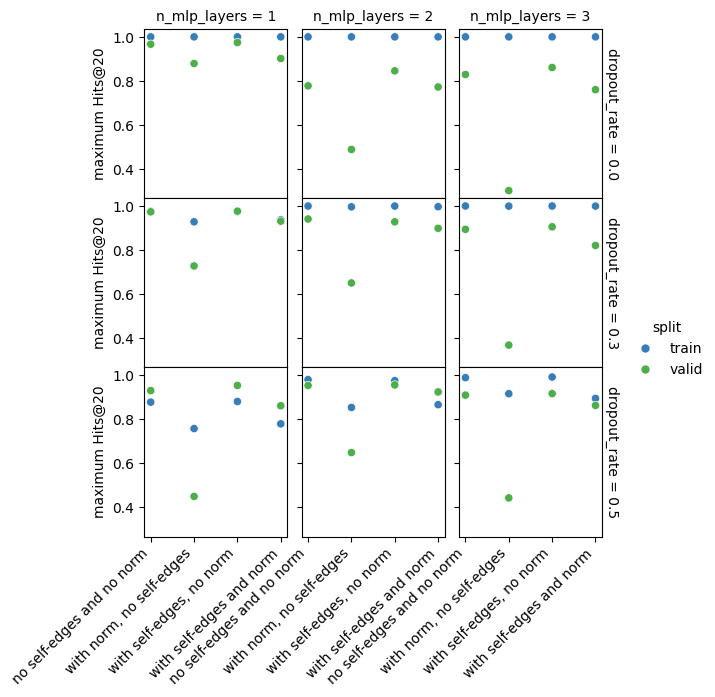

In [66]:
fig = sns.relplot(
  data=data,
  x="conv_layer",
  y="mean",
  row="dropout_rate",
  col="n_mlp_layers",
  hue="split",
  palette=DEFAULT_SPLIT_COLORS,
  facet_kws=dict(margin_titles=True, despine=False),
  height=2,
)
fig.figure.subplots_adjust(wspace=0.1, hspace=0)
for ax in fig.axes.flat:
  for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")
fig.set_axis_labels("", "maximum Hits@20");

There are many models in this plot, but one stands out in the upper-left corner: the best-performing model without dropout. It uses a simple convolutional setup (no self-edges, no normalization) and a single-layer link predictor. It’s notable that such a minimal configuration performs so well, suggesting that simpler models can still be highly effective. 

Other observations from the plot: 
- Degree normalization hurts almost everywhere. Both “with norm” columns show a noticeable drop in validation performance relative to their “no norm” counterparts. 
- Deeper MLP heads overfit more. Moving from one to three MLP layers widens the train–valid gap and very rarely yields a higher peak validation score. 
- Dropout does not consistently help, though some models with high dropout perform well, suggesting it’s not strictly harmful either. 
- Self-edges make little difference. The two “with self-edges” categories track their “no self-edges” twins closely, suggesting that this graph already conveys enough reciprocal information. 

Overall, the task appears quite forgiving—many configurations exceed 0.8 on validation—but the simplest, lowest-capacity model remains the most reliable choice.

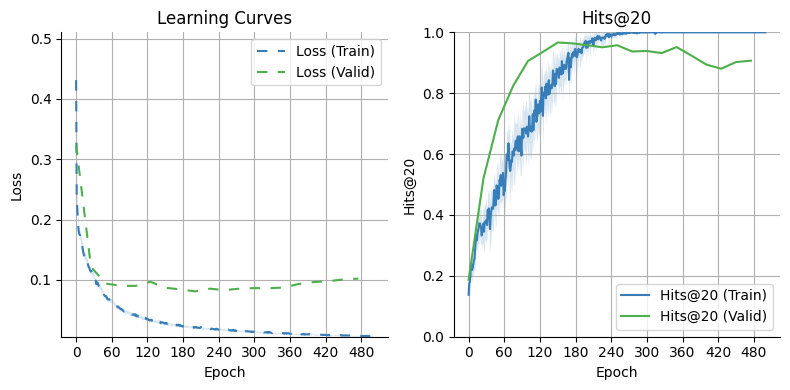

In [67]:
from dlfb.utils.metric_plots import from_df

metrics = all_metrics_df
metrics = from_df(
  metrics[
    (metrics["dropout_rate"] == 0.0)
    & (metrics["last_layer_self"] == False)
    & (metrics["degree_norm"] == False)
    & (metrics["n_mlp_layers"] == 1)
  ]
)

plot_learning(metrics);

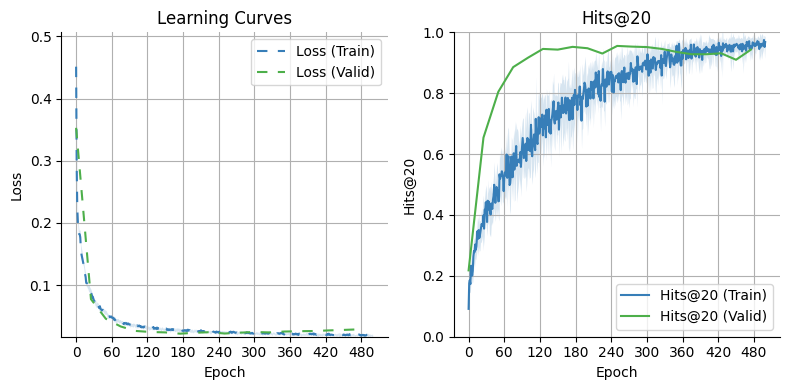

In [68]:
metrics = all_metrics_df
metrics = from_df(
  metrics[
    (metrics["dropout_rate"] == 0.5)
    & metrics["last_layer_self"]
    & (metrics["degree_norm"] == False)
    & (metrics["n_mlp_layers"] == 2)
  ]
)

plot_learning(metrics);

### 4.7.3. Train on a Larger Dataset


In [69]:
node_limit = 2134
rng = jax.random.PRNGKey(42)
rng, rng_dataset, rng_init, rng_train = jax.random.split(rng, 4)
dataset_splits = DatasetBuilder(path=assets("graphs/datasets")).build(
  node_limit, rng_dataset
)

model = DdiModel(
  n_nodes=dataset_splits["train"].n_nodes,
  embedding_dim=512,
  dropout_rate=0.3,
  last_layer_self=True,
  degree_norm=True,
  n_mlp_layers=2,
)

_, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input={
      "graph": dataset_splits["train"].graph,
      "pairs": dataset_splits["train"].pairs.get_dummy_input(),
    },
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=1000,
  eval_every=25,
  loss_fn=auc_loss,
  norm_loss=True,
  store_path=assets("graphs/models/larger_model"),
)

/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:67: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.graph = torch.load(pre_processed_file_path, 'rb')
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:138: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  train = torch.load(osp.join(path, 'train.pt'))
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  valid = torch.load(osp.join(path, 'valid.pt'))
/usr/local/lib/python3.12/dist-packages/ogb/linkproppred/dataset.py:140: UserWarning

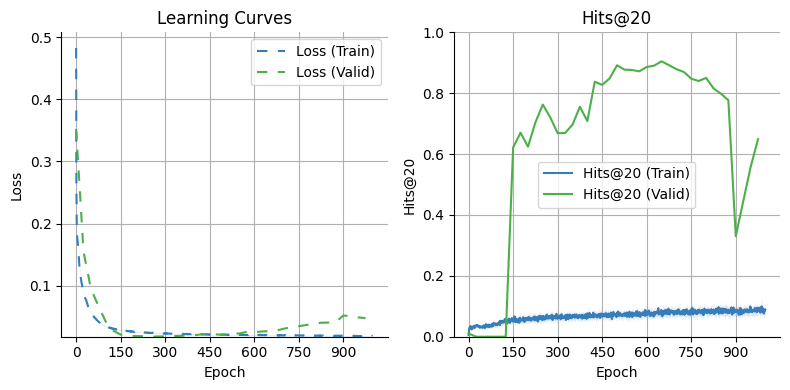

In [70]:
plot_learning(metrics);

The resulting learning curves in Figure 4-15 look quite different from the smaller-set runs. Validation Hits@20 climbs to ∼0.9—on par with our best earlier models—but training Hits@20 remains unexpectedly low, hovering near 0.1. This wide gap likely reflects the increased difficulty of distinguishing positives from a much larger and more diverse set of negatives in the denser graph. It may also indicate that even with an AUC-like loss, nailing top-k ranking metrics like Hits@20 remains challenging at scale. Either way, further work—such as improved negative sampling or top-k–specific objectives—may be needed to fully leverage the larger dataset, and we encourage you to explore further.

### 4.7.4. Extensions


## 4.8. Summary
